In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import sklearn
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

https://m.blog.naver.com/PostView.nhn?blogId=sexyit_2019&logNo=221603292906&proxyReferer=https:%2F%2Fwww.google.com%2F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 오디오 데이터
DATA_DIR = '/content/drive/My Drive/FreeResearch/음 파일/'
DATA_DIR_TRAIN = '/content/drive/My Drive/FreeResearch/dataset/train/'
DATA_DIR_TEST = '/content/drive/My Drive/FreeResearch/dataset/test/'

In [ ]:
wav, sr = librosa.load(DATA_DIR_TRAIN + '음100.wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (3874,)
length: 0.242125 secs


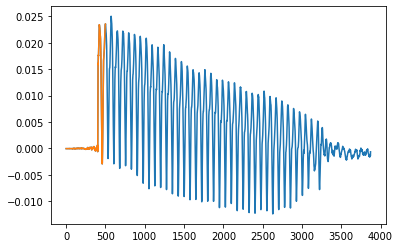

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
train_X = []
train_spectrograms = []
train_mel_spectograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것

In [ ]:
from unicodedata import normalize

In [ ]:
dataset0 = [] # 추임새

test_dataset = []
train_dataset = []

frame_length = 0.025
frame_stride = 0.001

In [ ]:
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))
print(input_nfft,input_stride)

400 16


In [ ]:
#train data set

i = 0

for filename in os.listdir(DATA_DIR_TRAIN):

  i+=1
  if i>= 10: break

  filename = normalize('NFC', filename) # 'ㅇㅡㅁ.wav' -> '음.wav'
  try:
    if '.wav' not in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR_TRAIN + filename, sr=16000)
  
    mfcc = librosa.feature.mfcc(wav)
    #mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 120)

    # 추임새/비추임새 구분하여 dataset에 추가
    if filename[0] == '외':
      train_dataset.append((padded_mfcc, 1))
    else:
      train_dataset.append((padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

# test data set

j = 0

for filename in os.listdir(DATA_DIR_TEST):

  j += 1
  if j >= 10: break

  filename = normalize('NFC', filename)
  try:
    if '.wav' not in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR_TEST + filename, sr=16000)

    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
  
    mfcc = librosa.feature.mfcc(wav)
    #mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 120)

    # 추임새/비추임새 구분하여 dataset에 추가
    if filename[0] == '외':
      test_dataset.append((padded_mfcc, 1))
    else:
      test_dataset.append((padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

# 데이터셋을 셔플
import random
random.shuffle(test_dataset)
random.shuffle(train_dataset)

train_mfccs = [a for (a,b) in train_dataset]
train_y = [b for (a,b) in train_dataset]

test_mfccs = [a for (a,b) in test_dataset]
test_y = [b for (a,b) in test_dataset]

print(type(train_mfccs))
print(len(train_mfccs))

train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

<class 'list'>
1696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: ignored

In [ ]:
# MFCC feature로 학습

In [ ]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

In [ ]:
ip = Input(shape=train_X_ex[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*3, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(32)(m)
#m = BatchNormalization()(m)
m = Activation("relu")(m)

op = Dense(2, activation='softmax')(m)

model = Model(ip, op)

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=10, #이거 숫자 바꿔!
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# model test

In [ ]:
wav, sr = librosa.load(DATA_DIR_TRAIN + '외100.wav', sr=16000)
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))
mfcc = librosa.feature.mfcc(wav,n_mfcc=100, n_mels=100, n_fft=input_nfft, hop_length=input_stride) #여기야 여기ㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣ!!!!!!!!!!!!!!!!!!!!!!!
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 40)

In [ ]:
padded_mfcc = np.expand_dims(padded_mfcc, 0)
padded_mfcc = np.expand_dims(padded_mfcc, -1)

In [ ]:
model.predict(padded_mfcc)

# model save

In [ ]:
model.save('/content/drive/My Drive/model/determine')